# Modelo de previsão de formação de hidratos em linhas de produção de petróleo e gás *Off-shore*

Na indústria do petróleo, assim como em outras atividades industriais tem crescido a demanda por encontrar formas de se realizar essas operações de forma segura, produtiva, com qualidade e com eficiência energética. Para isso o controle desses processos se faz necessário, a fim de se evitar a ocorrência de eventos indesejados, como falhas ou mal funcionamentos. Falhas são caracterizadas por desvios ou anomalias na operação normal de um processo, que pode ser caracterizadas por sinais de bibração de uma máquina, sensores de temperatura e pressão de um processo e etc.

Na indústria do petróleo falhas em poços de petróleo podem causar grandes perdas de produção. A Petrobras S.A (Brasil) estima que durante o ano de 2016 cerca de 1,5 milhões de barris de petróleo foram deixados de ser produzidos devido a falhas em seus poços, o que correspondia na época uma **perda de arrecadação de USD 75,7 milhões**, levando em consideração que o **preço médio do barril de petróleo na época era de USD 50,0.**

Existem diversas falhas que podem acontecer em poços de petróleo e suas linhas de produção, mas nesse trabalho focaremos na detecção da falha "formação de hidratos". Em particular, essa falha pode ocorrer em poços *off- shore* e causar grandes problemas operacionais pois na sua ocorrência o poço pode parar completamente de produzir devido a grande obstrução causado pela formação de hidratos nas linhas de escoamento do óleo do leito marinho até as plataformas de produção. Segundo dados da própria Petrobras UO- Rio, entre os de 2014 e 2017 essa foi a falha que causou maior perda cumulativa de óleo.

Hidratos são compostos cristalinos, de aparência semelhantes ao gelo, formados pela reação do gás natural com a água. Para que o hidrato se forme é necessário que se tenha água e gás na presença de alta pressão, baixas temperaturas. Condições essas encontradas no escoamento da mistura produzida em reservatórios localizados em elevadas lâminas d'água, como é o caso dos reservatórios do Pré-Sal.

Nesse estudo foram utilizados dados reais e simulados de um processo de produção de petróleo com a medição de variáveis e a detecção de formação de hidratos nas linhas de produção dos poços. Os dados foram coletados e produzidos durante os anos de 2017 e 2018 e conta com 81 instâncias simuladas e 3 instâncias reais.

O objetivo desse estudo foi realizar uma análise exploratória dos dados para entender melhor os dados e o comportamento das variáveis ao longo do processo, além de identificar variáveis congeladas e faltantes. Posteriormente foi realizado a criação de *Machine Learning* para classificação binária da condição dos poços. Para a criação dos modelos foi optado por utilizar uma metodologia que sugeri a criação de modelos mais simples até modelos mais robustos, avaliando-os e escolhendo aquele que melhor se encaixar a situação problema.

Descrição das variáveis do processo:
- **P- PDG:** Pressão na PDG (Pa);
- **P- TPT:** Pressão no Transdutor de pressão e Temperatura do poço (Pa);
- **T- TPT:** Temperatura no Transdutor de pressão e Temperatura do poço (°C);
- **P-MON-CKP:** Pressão a montante na PCK (Válvula choke de produção) (Pa);
- **T-JUS-CKP:** Temperatura a jusante na PCK (°C);
- **P-JUS-CKGL:** Pressão a jusante na GLCK (Gás lift) (Pa);
- **T-JUS-CKGL:** Temperatura a jusante na GLCK (Gás lift) (°C);
- **QGL:** Vazão do Gás lift (m³/s).

Ferramentas e dados utilizados:
- **Manipulação, limpeza e análise exploratória dos dados**: Pandas, Numpy, missingno;
- **Visualização dos dados**: Matplotlib;
- **Machine Learning**: Scikit- Learn (Modelos de classificação Regressão Logística e Árvores de Decisão)
- **Fonte dos dados**: https://www.sciencedirect.com/science/article/pii/S0920410519306357?via%3Dihub

## Importando bibliotecas

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import missingno
import glob
import os

## Carregando o banco de dados e as Tags das variáveis

In [2]:
dados = 'Hydrate_formation'

In [3]:
tags = {'P-PDG':'Pa', 
        'P-TPT':'Pa', 'T-TPT':'°C',
         'P-MON-CKP':'Pa', 'T-JUS-CKP':'°C', 
         'P-JUS-CKGL':'Pa', 'T-JUS-CKGL':'°C',
         'QGL': 'm³/s'}

var = ['Pressão na PDG (Medidor de fundo)',
         'Pressão no TPT (Transdutor de temp. e pressão)',
         'Temperatura no TPT (Transdutor de temp. e pressão)',
         'Pressão upstream na PCK (Válvula choke de produção)',
         'Temperatura downstream na PCK (Válvula choke de produção)',
         'Pressão downstream na GLCK (Gás lift)',
         'Temperatura downstream na GLCK (Gás lift)',
         'Vazão do Gas lift']

reference_table = pd.DataFrame(index=np.arange(1,len(var)+1))
reference_table.index.name='Variável'
reference_table['Tag'] = tags.keys()
reference_table['Nome'] = var
reference_table['Unidades'] = tags.values()
reference_table

,Tag,Nome,Unidades
Variável,,,
1,P-PDG,Pressão na PDG (Medidor de fundo),Pa
2,P-TPT,Pressão no TPT (Transdutor de temp. e pressão),Pa
3,T-TPT,Temperatura no TPT (Transdutor de temp. e pres...,°C
4,P-MON-CKP,Pressão upstream na PCK (Válvula choke de prod...,Pa
5,T-JUS-CKP,Temperatura downstream na PCK (Válvula choke d...,°C
6,P-JUS-CKGL,Pressão downstream na GLCK (Gás lift),Pa
7,T-JUS-CKGL,Temperatura downstream na GLCK (Gás lift),°C
8,QGL,Vazão do Gas lift,m³/s


In [4]:
%%time

files = [f for f in os.listdir(dados) if os.path.isfile(os.path.join(dados, f))]
files

dfs = {}

for file in files:
    
    dfs[file[:-4]] = pd.read_csv(f'{dados}/{file}', index_col = 0,
                     parse_dates = True).rename_axis(None)

n_real = []
n_sim = []
    
for key in dfs.keys():
    if 'SIMULATED' in key:
        n_sim.append(int(key[13:15]))
        continue
    else:
        n_real.append(int(key[8:10]))

CPU times: total: 6.77 s
Wall time: 7.41 s


### Separando os dados em instâncias reais e simuladas

In [5]:
%%time

n_instancia = 0
n_simulados = 0
n_reais = 0
dados_simulados = pd.DataFrame()
dados_reais = pd.DataFrame()


file_list = glob.glob(dados + "/*.csv")
todos_dados = pd.DataFrame(pd.read_csv(file_list[0]))

for i in range(0,(len(file_list))):

  if 'SIMULATED' in file_list[i]:
    simulados = pd.read_table(file_list[i], sep = ',')
    df = pd.DataFrame(simulados)
    df['N_Simulacao'] = n_sim[n_simulados]
    dados_simulados = pd.concat([dados_simulados, df], axis = 0, ignore_index = True)
    #dados_simulados = pd.concat([dados_simulados, indice_sim], axis = 0, ignore_index = True)
    n_simulados +=1
  else:
    reais = pd.read_table(file_list[i], sep = ',')
    df = pd.DataFrame(reais)
    df['Inst_real'] = n_real[n_reais]
    dados_reais = pd.concat([dados_reais, df], axis = 0, ignore_index = True)
    n_reais += 1

  data = pd.read_table(file_list[i], sep = ',')
  df_ = pd.DataFrame(data)
  todos_dados = pd.concat([todos_dados, df_], axis = 0, ignore_index = True)
  n_instancia +=1

print("Número de instâncias:", n_instancia)
print("Número de instâncias simuladas:", n_simulados)
print("Número de instâncias reais:", n_reais)

Número de instâncias: 84
Número de instâncias simuladas: 81
Número de instâncias reais: 3
CPU times: total: 17.4 s
Wall time: 18 s


## Análise de dados

In [ ]:
dados_simulados.dtypes

In [ ]:
dados_reais.dtypes

### Analisando dados faltantes com a biblioteca <i>missingno<i>

In [ ]:
missingno.bar(dados_simulados)

In [ ]:
missingno.bar(dados_reais)

In [ ]:
dados_simulados.isna().sum()

In [ ]:
dados_reais.isna().sum()

Para os **dados simulados** não existe a presença de valores faltantes (NaN), entretanto as variáveis ***Pressão e Temperatura downstream na GLCK (Gás lift)*** e ***Vazão do Gas lift*** não possuem registros.

Já para os **dados reais** existe a presença de valores faltantes para a variável *Class*, e as variáveis ***Temperatura downstream na PCK*** e ***Temperatura downstream na GLCK*** não possuem registros.

**A estatégia adotada para resolver o problema dos dados faltantes será a interpolação dos valores para os valores contínuos. Já para as variáveis de classe será feito a remoção, por se tratar de poucas observações (0.4%).**

### Comparando as instâncias reais e simuladas

In [ ]:
color_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
plt.rc('font', family='serif', size=12) # controls default text sizes
plt.rc('axes', titlesize=14)     # fontsize of the axes title
plt.rc('axes', labelsize=13)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=13)    # fontsize of the tick labels
plt.rc('ytick', labelsize=13)    # fontsize of the tick labels
plt.rc('legend', fontsize=12)    # legend fontsize
plt.rc('figure', titlesize=14)  # fontsize of the figure title

In [ ]:
from scipy.stats.distributions import kappa4
fig, ax1 = plt.subplots(4, 2, figsize=(16, 12))
rotulos = ['P-PDG',	'P-TPT',	'T-TPT',	'P-MON-CKP',	
           'T-JUS-CKP',	'P-JUS-CKGL',	'T-JUS-CKGL',	'QGL']

for key in sorted(dfs.keys()):
    
    if 'WELL' in key:
        c = color_cycle[1]
        lw = 0.3
        ls='--'
        alpha=1
        ms=0.1
    elif 'SIMULATED' in key:
        c = 'k'
        lw = 0.3
        ls=''
        alpha=0.3
        ms=0.1
        
    df_plot = dfs[key]

    for i in range(4):
        real = ax1[i,0].plot(np.arange(df_plot.shape[0]),
                    (df_plot.iloc[:,i]-df_plot.iloc[:,i].mean())/df_plot.iloc[:,i].std(ddof=1), 
                    c=c,linewidth=lw,ls=ls,marker='.',ms=ms,alpha=alpha)
        simulated = ax1[i,1].plot(np.arange(df_plot.shape[0]),
                    (df_plot.iloc[:,i+4]-df_plot.iloc[:,i+4].mean())/df_plot.iloc[:,i+4].std(ddof=1),
                     c=c,linewidth=lw,ls=ls,marker='.',ms=ms,alpha=alpha)
        ax1[i][0].set_ylabel("{}".format(rotulos[i]),rotation=0,fontsize=14)
        ax1[i][1].set_ylabel("{}".format(rotulos[i+4]),rotation=0,fontsize=14)
        
        for j in range(2):
            ax1[i][j].set_yticks([])
            ax1[i][j].spines["top"].set_visible(False)
            ax1[i][j].spines["right"].set_visible(False)
            ax1[i][j].spines["left"].set_visible(False)
            if i<(8-1):
                ax1[i][j].set_xticks([])
                ax1[i][j].spines["bottom"].set_visible(False)
                ax1[i][j].xaxis.set_ticks_position('none')
            else:
                for label in ax1[i][j].get_xticklabels():
                    label.set_rotation(45)
                    label.set_ha('right')

Nos gráficos acima, os dados simulados estão representados pelas linhas pretas, enquanto que os valores reais estão representados pelas linhas laranjas. Os dados foram colocados em mesma escala para melhorar visualização do comportamento através da padronização para a média 0 e desvio padrão em 1.

Percebe-se que os gráficos reais e simulados apresentam as mesmas tendências para algumas variáveis, como é o caso das variáveis: **P- PDG**, **P- TPT**, **T-TPT**. Para o gráfico da variável **P-MON-CKP** em uma das instância reais, pé perceptível o congelamento da variável ao longo de toda a medião (linha reta), assim como pode ser percebido também na variável **QGL**.

### Visualizando o comportamento das variáveis em relação ao estado do sistema

In [ ]:
%%time
EVENT = 8
fig = plt.figure(constrained_layout=True, figsize=(18, 120))
subfigs = fig.subfigures(21, 4, wspace = 0.07)

j=0

for key in sorted(dfs.keys()):
    
    if 'WELL' in key:
        continue
    elif 'SIMULATED' in key:
        pass
        
    df_plot = dfs[key]
    
    ax1 = subfigs.ravel()[j].subplots(8, 1, sharex=True)
    
    for i in range(8):
        ax1[i].plot(df_plot.index,df_plot.iloc[:,i],c='k',linewidth=0.8)
        ax1[i].set_ylabel("{}".format(rotulos[i]),rotation=0,fontsize=14)
        ax1[i].set_yticks([])
        ax1[i].spines["top"].set_visible(False)
        ax1[i].spines["right"].set_visible(False)
        ax1[i].spines["left"].set_visible(False)
        ax1[i].fill_between(df_plot.index, ax1[i].get_ylim()[0], ax1[i].get_ylim()[1],
                               where=(df_plot['class']==(0)), 
                               alpha=0.6,color='green',)        
        ax1[i].fill_between(df_plot.index, ax1[i].get_ylim()[0], ax1[i].get_ylim()[1],
                               where=(df_plot['class']==(EVENT+100)), 
                               alpha=0.2,color='red',)
        ax1[i].fill_between(df_plot.index,ax1[i].get_ylim()[0], ax1[i].get_ylim()[1],
                               where=(df_plot['class']==EVENT), 
                             alpha=0.6,color='red')
        ax1[i].set_xticks([])
        ax1[i].spines["bottom"].set_visible(False)
        ax1[i].xaxis.set_ticks_position('none')
    ax1[0].set_title(f'Simulações {int(key[-5:])}')
    
    j+=1

Os gráficos acima mostram o comportamento das variáveis ao longo do tempo. O *background* dos gráficos mostram os estados de funcionamento dos poços, sendo respectivamente:

- <font color="green"><b>Verde</font></b>: estado normal (sem falha);
- <font color="pink"><b>Rosa claro</font></b>: estado transiente, ou seja, é um estado interpretado como um pré-evento para para o estado de falha;
- <font color="red"><b>Vermelho escuro</font></b>: estado de falha.

Percebe-se que em algumas simulações não existe a presença do estado de falha.
É observado nos gráficos de todas as simulações que a tendência das variáveis são as mesmas quando o sistema muda do estado <font color="green">normal</font></b>, para o estado <font color="pink">transiente </font></b> e por fim para o estado de <font color="red">falha</font></b>:
- As variáveis P- PDG e P- TPT aumentam;
- As variáveis T- TPT, P-MON- CKP e T-JUS-CKP dominuem.

In [ ]:
%%time
EVENT = 8
fig, ax1 = plt.subplots(8,3,figsize=(20,8), sharex = 'col', sharey = False)

j=0

for key in sorted(dfs.keys()):
    
    if 'WELL' in key:
        pass
    elif 'SIMULATED' in key:
        continue
        
    df_plot = dfs[key]
    
    for i in range(8):
        ax1[i][j].plot(df_plot.index,df_plot.iloc[:,i],c='k',linewidth=0.8)
        ax1[i][j].set_ylabel("{}".format(rotulos[i]),rotation=0,fontsize=14)
        ax1[i][j].set_yticks([])
        ax1[i][j].spines["top"].set_visible(False)
        ax1[i][j].spines["right"].set_visible(False)
        ax1[i][j].spines["left"].set_visible(False)
        ax1[i][j].fill_between(df_plot.index, ax1[i,j].get_ylim()[0], ax1[i,j].get_ylim()[1],
                               where=(df_plot['class']==0), 
                               alpha=0.2,color='green')        
        ax1[i][j].fill_between(df_plot.index, ax1[i,j].get_ylim()[0], ax1[i,j].get_ylim()[1],
                               where=(df_plot['class']==(EVENT+100)), 
                               alpha=0.2,color='red')
        ax1[i][j].fill_between(df_plot.index,ax1[i,j].get_ylim()[0], ax1[i,j].get_ylim()[1],
                               where=(df_plot['class']==EVENT), 
                             alpha=0.6,color='red')
        if i<(8-1):
            ax1[i][j].set_xticks([])
            ax1[i][j].spines["bottom"].set_visible(False)
            ax1[i][j].xaxis.set_ticks_position('none')
        else:
            for label in ax1[i][j].get_xticklabels():
                label.set_rotation(45)
                label.set_ha('right')
                
    ax1[0][j].set_title(f'Poço {int(key[8:10])}')
    
    j+=1

Devido a presença de muitas variávies com valores congelados foi optado nessa modelagem em eliminar as instâncias de dados reais e contruir um modelo apenas baseado em dados simulados.

## Preparando o conjunto de dados para treinamento dos modelos

### Excluindo colunas vazias

In [6]:
dados_simulados.drop(['timestamp', 'P-JUS-CKGL',	'T-JUS-CKGL',	'QGL'], axis=1, inplace=True)
dados_simulados.isna().sum()

P-PDG          0
P-TPT          0
T-TPT          0
P-MON-CKP      0
T-JUS-CKP      0
class          0
N_Simulacao    0
dtype: int64

In [7]:
dados_simulados

,P-PDG,P-TPT,T-TPT,P-MON-CKP,T-JUS-CKP,class,N_Simulacao
0,27897490.0,19824230.0,125.685900,4059666.0,97.55283,0,1
1,27897450.0,19824230.0,125.685900,4059666.0,97.55283,0,1
2,27897360.0,19824230.0,125.685900,4059666.0,97.55283,0,1
3,27897430.0,19824230.0,125.685900,4059666.0,97.55282,0,1
4,27897500.0,19824230.0,125.685900,4059666.0,97.55282,0,1
...,...,...,...,...,...,...,...
2186915,33586320.0,28076270.0,3.253794,4002285.0,37.74498,108,81
2186916,33586440.0,28076420.0,3.253723,4002285.0,38.21421,108,81
2186917,33586900.0,28076490.0,3.253835,4002278.0,38.75061,108,81
2186918,33586480.0,28076560.0,3.253942,4002255.0,39.31084,108,81


### Transformando a variável alvo (estado do sistema)

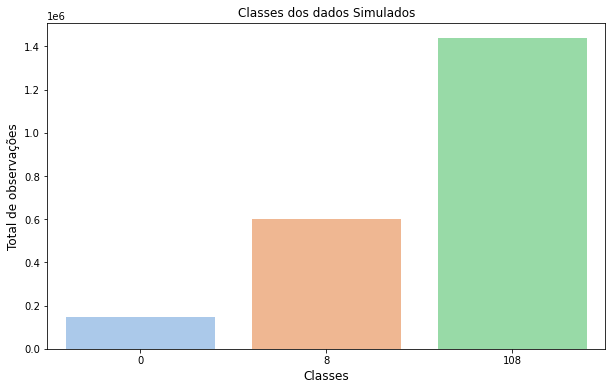

In [8]:
plt.figure(figsize = (10,6))
sns.countplot(x=dados_simulados['class'], palette = "pastel")
plt.title("Classes dos dados Simulados")
plt.xlabel('Classes', fontsize = 12)
plt.ylabel('Total de observações', fontsize = 12)
plt.show()

Nitidamente os dados estão desbalanceados, porém o desafio será treinar um modelo que lidar com esse tipo de situação.

In [9]:
dados_simulados['class'].replace(8, 1, inplace = True)
dados_simulados['class'].replace(108, 1, inplace = True)
dados_reais['class'].replace(8, 1, inplace = True)
dados_reais['class'].replace(108, 1, inplace = True)

Outra estratégia adota aqui, é assumir que o estado transiente será considerado como da mesma classe da falha. Ou seja, estado transiente (class 8) e estado de falha (class 108) formaram um único estado (class 1). Essa condição foi levada em consideração pois, se estamos pensando em construir um modelo de classificação para detectar de forma antecipada a parada do poço pela formação de hidratos, quanto mais antecipado for esta detecção, mais cedo poderá ser realizado uma evitar a falha.

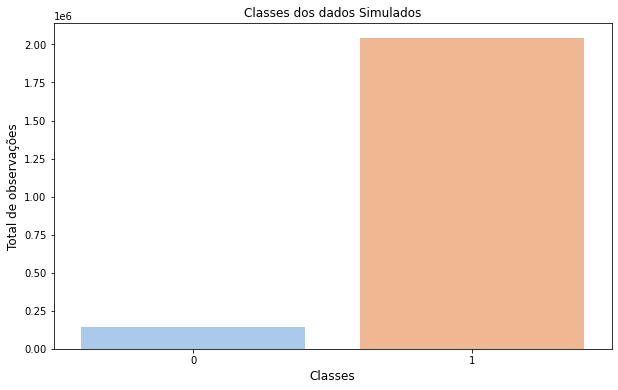

In [10]:
plt.figure(figsize = (10,6))
sns.countplot(x=dados_simulados['class'], palette = "pastel")
plt.title("Classes dos dados Simulados")
plt.xlabel('Classes', fontsize = 12)
plt.ylabel('Total de observações', fontsize = 12)
plt.show()

### Separando o conjunto de dados em variáveis de entrada (X) e saída (y)

In [11]:
X = dados_simulados.iloc[:,:-2]
y = dados_simulados.iloc[:,-2]

In [12]:
#from imblearn.under_sampling import NearMiss
#nm1 = NearMiss(version=1)
#X, y = nm1.fit_resample(X, y)
y.value_counts()/y.shape[0]

1    0.933331
0    0.066669
Name: class, dtype: float64

### Separando o banco de para treinamento e teste

In [13]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42, shuffle = True)

### Padronizando os dados de entrada utilizando

In [14]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)
print(X_train)
print(X_test)

[[ 0.70522211  0.93840404 -0.88285042 -0.3088431  -1.1878724 ]
 [ 0.68142251  0.75454869 -0.88352447 -1.50378074 -0.63343927]
 [ 0.70697779  1.16421419 -0.88340768 -0.30854813 -1.32048035]
 ...
 [-1.22331591 -1.32558459  1.17175758 -1.4405566   0.99178013]
 [-0.51968519 -1.32917695  1.20590374 -0.28022613  1.37454476]
 [-0.0193568   0.02844546  1.14972065 -0.28609808  0.66676652]]
[[ 0.7136058   0.64224967 -0.84523698  2.08093007 -0.3873274 ]
 [-1.10367374 -1.14166327  1.16233575 -0.27244283  1.01151525]
 [ 0.70439163  0.80506651 -0.88345225  2.08117488 -1.34549778]
 ...
 [-0.97211125 -1.06458156  1.17111725  0.91203289  1.08904044]
 [-0.73514151 -0.97987526  1.18557268 -0.28151528  1.22989357]
 [ 0.69868566  0.63573211 -0.87290881 -0.30873025 -0.36837999]]


## Treinamento dos modelos de classificação

A metodologia adota nessa etapa será a de usar diferentes técnicas de Aprendizagem de Máquina e selecionar aquela que tiver melhor desempenho através da avaliação das métricas de <b>acurácia, precisão, recall e F1- score.<b>

### Modelo de regressão logística

In [15]:
%%time
from sklearn.linear_model import LogisticRegression
classificador1 = LogisticRegression(dual = False, tol = 1e-5,
                                   random_state = 0, solver = 'newton-cg')
classificador1.fit(X_train, y_train)

CPU times: total: 26.2 s
Wall time: 13.5 s


C:\Users\yagom\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\yagom\anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


LogisticRegression(random_state=0, solver='newton-cg', tol=1e-05)

In [16]:
y_pred1 = classificador1.predict(X_test)

#### Verificando as métricas do modelo

Matriz de confusão sem normalização
[[   511  43108]
 [   478 611979]]
Matriz de confusão normalizada
[[1.17150783e-02 9.88284922e-01]
 [7.80462955e-04 9.99219537e-01]]


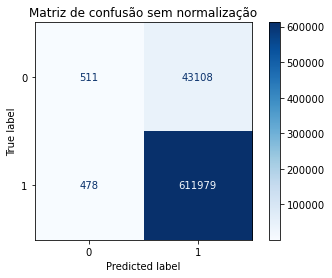

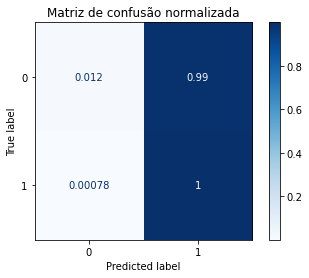

In [17]:
from sklearn.metrics import ConfusionMatrixDisplay

titles_options = [
    ("Matriz de confusão sem normalização", None),
    ("Matriz de confusão normalizada", "true"),
]
for title, normalize in titles_options:
    disp = ConfusionMatrixDisplay.from_estimator(
        classificador1,
        X_test,
        y_test,
        cmap=plt.cm.Blues,
        normalize=normalize,
    )
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

In [18]:
from sklearn import metrics

print('\nRelatório das métricas de classificação para dados de teste:\n')
print(metrics.classification_report(y_test, y_pred1))


Relatório das métricas de classificação para dados de teste:

              precision    recall  f1-score   support

           0       0.52      0.01      0.02     43619
           1       0.93      1.00      0.97    612457

    accuracy                           0.93    656076
   macro avg       0.73      0.51      0.49    656076
weighted avg       0.91      0.93      0.90    656076



Percebe-se que o modelo obteve um <b>baixo desempenho em relação as métricas de precisão, recall e f1-score</b>, apesar de apresentar uma <b>boa acurácia</b>. Esse padrão de comportamento das métricas, indica que o modelo não soube lidar bem com o banco de dados desbalanceado, tendendo a classificar a maioria das amostras como estado de falha (classe 1), este fato é mais perceptível quando analisamos a matriz de confusão.

Se tratando de um problema de classificação se analisarmos apenas a métrica de acurácia, podemos ter a falsa sensação de que o modelo é rebusto o suficiente para fazer novas previsões, porém, em caso de utilização de dados desbalanceados deve-se levar em consideração a ocorrência do <b>"paradoxo da acurácia"</b>, que é quando o modelo apresenta bons resultados de acurácia, entretanto quando analisamos a matriz de confusão ou outras métricas de classificação, nestas o modelo possui um baixo desempenho.

### Modelo de Árvore de Decisão

In [19]:
%%time
from sklearn.tree import DecisionTreeClassifier
classificador2 = DecisionTreeClassifier(criterion= 'entropy', random_state = 42)
classificador2.fit(X_train, y_train)

CPU times: total: 8.12 s
Wall time: 9.59 s


DecisionTreeClassifier(criterion='entropy', random_state=42)

In [20]:
y_pred2 = classificador2.predict(X_test)

#### Verificando as métricas do modelo

Matriz de confusão sem normalização
[[ 43617      2]
 [     8 612449]]
Matriz de confusão normalizada
[[9.99954148e-01 4.58515784e-05]
 [1.30621415e-05 9.99986938e-01]]


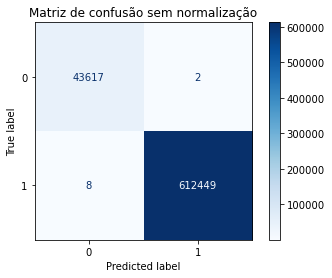

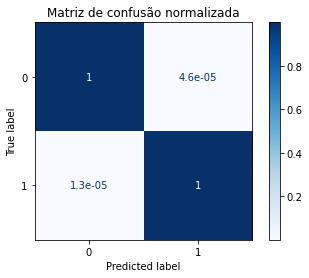

In [21]:
from sklearn.metrics import ConfusionMatrixDisplay

titles_options = [
    ("Matriz de confusão sem normalização", None),
    ("Matriz de confusão normalizada", "true"),
]
for title, normalize in titles_options:
    disp = ConfusionMatrixDisplay.from_estimator(
        classificador2,
        X_test,
        y_test,
        cmap=plt.cm.Blues,
        normalize=normalize,
    )
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

In [22]:
from sklearn import metrics

print('\nRelatório das métricas de classificação para dados de teste:\n')
print(metrics.classification_report(y_test, y_pred2))


Relatório das métricas de classificação para dados de teste:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     43619
           1       1.00      1.00      1.00    612457

    accuracy                           1.00    656076
   macro avg       1.00      1.00      1.00    656076
weighted avg       1.00      1.00      1.00    656076



O modelo de Árvores de Decisão conseguiu apresentar o desempenho muito superior ao modelo de Regressão Logística, apresentando bons valores nas métricas de desempenho. Porém, nesse primeiro teste com o modelo de árvore foi deixado que a árvore crescesse de forma indiscriminada, já que não foram definidos a profundidade máxima da árvore (max_depth) e o número mínimo de amostras em um nó (folha) (min_samples_leaf), que controlam o *overfitting* do modelo. 

Para controlar a poda da árvore e consequentemente o <i>overfitting</i>, será utilizada a função ***.cost_complexity_pruning_path*** do *scikit-learn* para controlar os hiperparâmetros do modelo **min_samples_leaf e max_depth**

#### Modelo de Árvore sem a poda

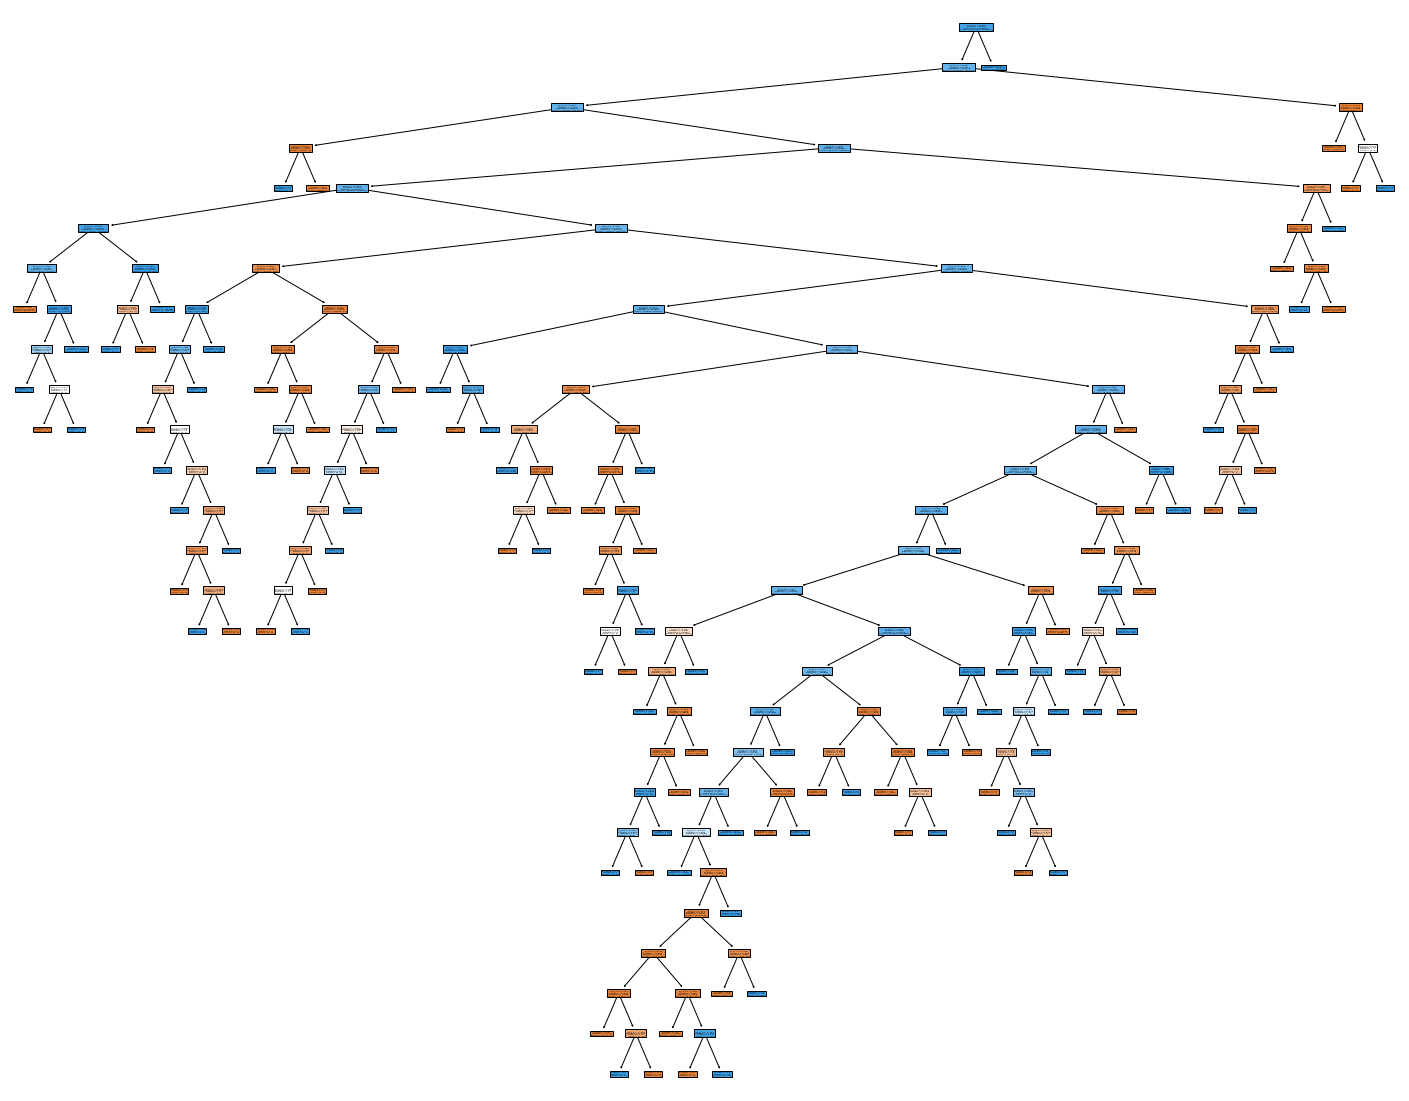

In [23]:
from sklearn import tree

fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(classificador2,
                   filled=True)

25 divisões (splits) foram realizadas.

#### Modelo de árvore com a poda

In [24]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

clf = DecisionTreeClassifier(criterion= 'entropy', random_state=0)
path = clf.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

Text(0.5, 1.0, 'Impureza das folhas vs Valor de alfa para os dados de treinamento')

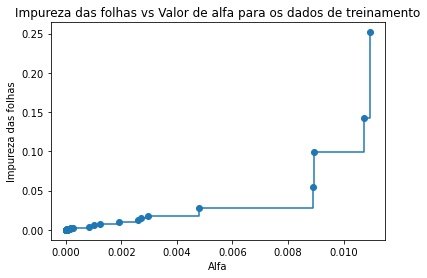

In [25]:
fig, ax = plt.subplots()
ax.plot(ccp_alphas[:-1], impurities[:-1], marker="o", drawstyle="steps-post")
ax.set_xlabel("Alfa")
ax.set_ylabel("Impureza das folhas")
ax.set_title("Impureza das folhas vs Valor de alfa para os dados de treinamento")

O gráfico mostra o aumento da impureza dos nós a medida que se aumenta o valor de alfa (controle da poda da árvore).
Quando Alfa é igual a 0 o modelo de árvore não sofre poda. A medida que o valor de alfa aumenta, a árvore é podada. O desafio é encontrar um valor de alfa em que controle o sobreajuste da árvore e um <i>underfit.

In [28]:
%%time
clfs = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(criterion= 'entropy', random_state=0, ccp_alpha=ccp_alpha)
    clf.fit(X_train, y_train)
    clfs.append(clf)

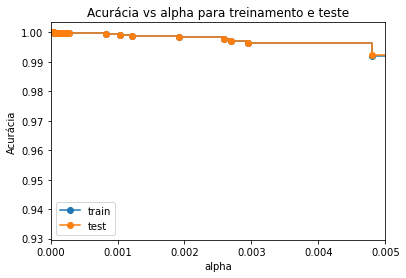

In [30]:
train_scores = [clf.score(X_train, y_train) for clf in clfs]
test_scores = [clf.score(X_test, y_test) for clf in clfs]

fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("Acurácia")
ax.set_title("Acurácia vs alpha para treinamento e teste")
ax.plot(ccp_alphas, train_scores, marker="o", label="train", drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores, marker="o", label="test", drawstyle="steps-post")
ax.set_xlim(0, 0.005)
ax.legend()
plt.show()

No gráfico de Acurácia vs. Alfa, observa-se quando alfa é próximo de 0, a acurácia para teste e treino é igual a 1. A medida alfa aumenta a árvore é podada, e a acurácia do modelo diminui. 
**O melhor valor de Alfa é 0.002.**

In [44]:
modelo = DecisionTreeClassifier(criterion= 'entropy', random_state=42, ccp_alpha=0.002)
modelo.fit(X_train, y_train)
y_pred = modelo.predict(X_test)

In [45]:
# Metricas de classificação
# =========================
from sklearn import metrics

print('\nRelatório das métricas de classificação para dados de teste:\n')
print(metrics.classification_report(y_test, y_pred))


Relatório das métricas de classificação para dados de teste:

              precision    recall  f1-score   support

           0       0.97      1.00      0.99     36655
           1       1.00      1.00      1.00    510075

    accuracy                           1.00    546730
   macro avg       0.99      1.00      0.99    546730
weighted avg       1.00      1.00      1.00    546730



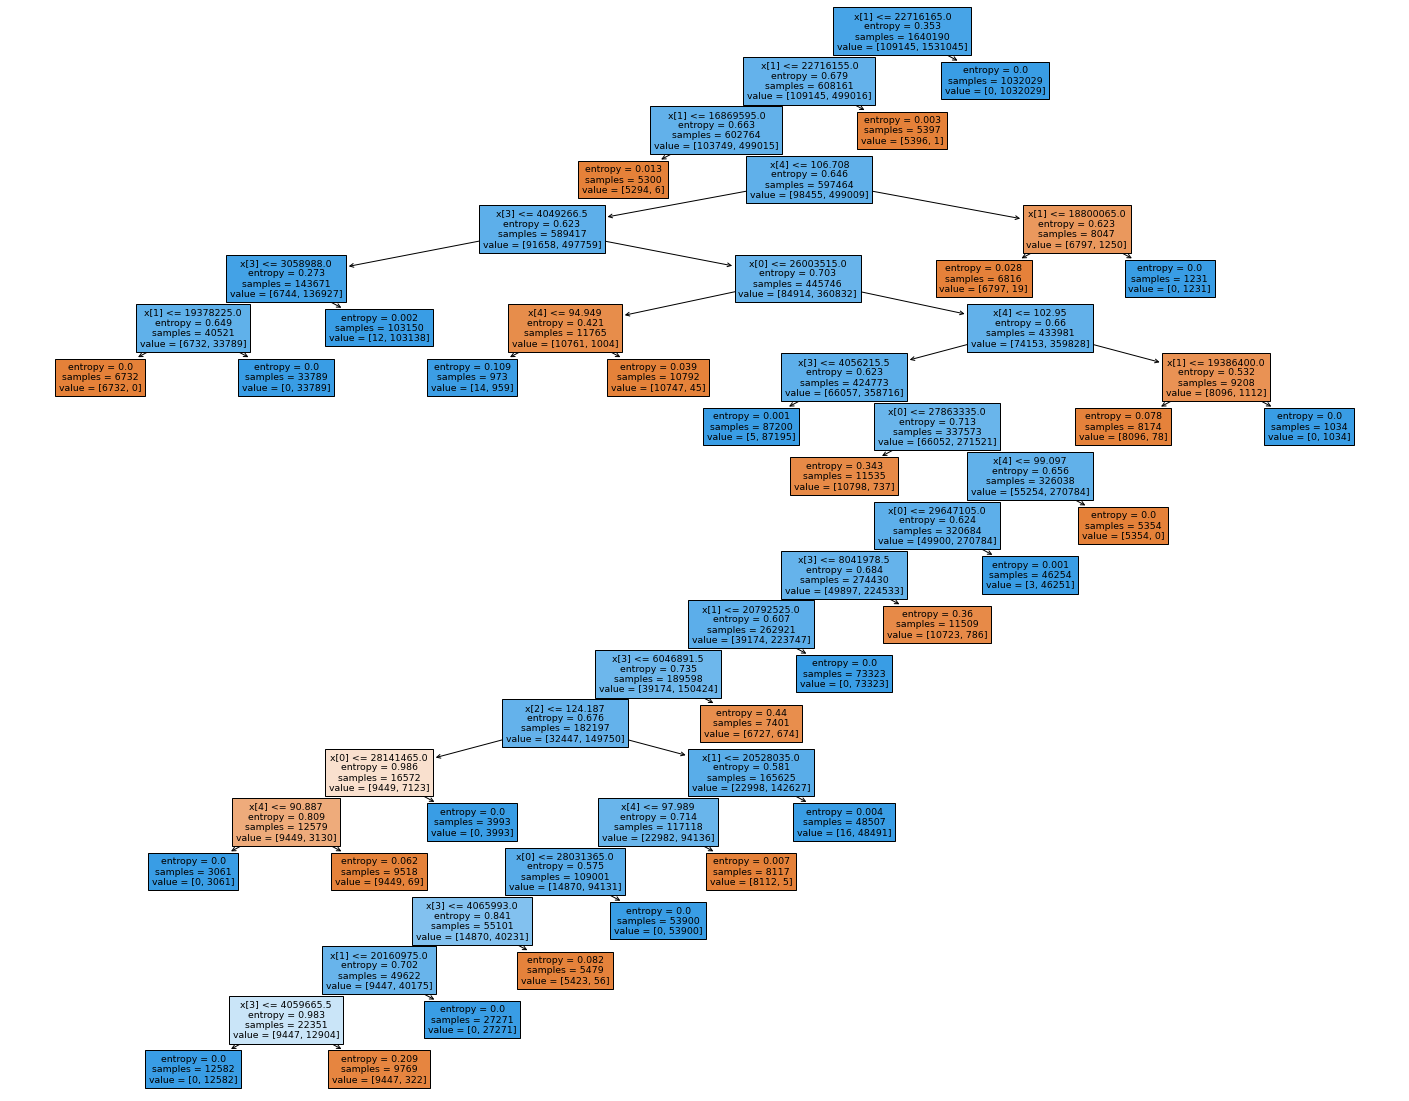

In [46]:
from sklearn import tree

fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(modelo,
                   filled=True)

Com o valor de alfa ideal (0,002), foi obtido uma árvore com menos nós, onde a profundidade total (max_depth) é igual a 21.

### Importância das varávies no modelo final de árvores

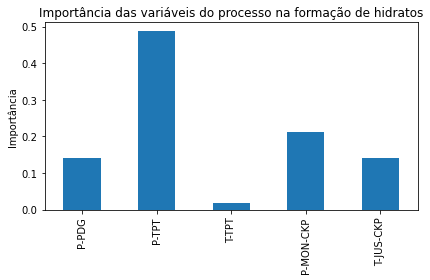

In [86]:
importances = modelo.feature_importances_
feature_names = [f"{X.columns[i]}" for i in range(X.shape[1])]

forest_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots()
forest_importances.plot.bar(ax=ax)
ax.set_title("Importância das variáveis do processo na formação de hidratos")
ax.set_ylabel("Importância")
fig.tight_layout()

A partir da extração da importância de cada uma dasvariáveis do processo de produção de petróleo off-shore, é possível observar que a variável <b>"P- TPT" (Pressão no transdutor localizado na cabeça do poço) possui maior influência no processo de formação de hidratos</b> durante a produção de petróleo e gás, seguido da variável <b>"P-MON-CKP" (Pressão a montante da válvula de choke -superfície).</b>